# СМЕШНЫЕ СЛОВА
by Паша Чернышев и Лиза Дроздовская

**Что мы хотели сделать?**

    С помощью машинного обучения понять, что делает некоторые слова смешными (вот просто смешными, без всякой причины). Программа максимум – еще и научить машину предсказывать, смешное ли слово.
    
**Как мы получили данные?**
    
1. Гугл форма 
   
    Сначала мы решили посмотреть, что люди вообще имеют в виду под "смешными словами". Мы сделали гугл форму с открытыми ответами. В ней было два вопроса: Какие слова вам кажутся смешными? Почему они смешные? На этот опрос ответило 124 человека. После чистки осталось 674 уникальных слова, которые мы назвали "изначально смешными". 72 из них были предложены больше одного раза.
         
2. Создаем список слов
 
    Чтобы сбалансировать выборку, мы загрузили список из 1575 случайных слов (леммы; >4 символов; без имен собственных) из корпуса [ГИКРЯ](http://www.webcorpora.ru/) и разбавили ими наши смешные слова. Получилось всего 2250 (30% смешные, 70% несмешные.
    
3. Создаем эксперимент    

    На следующем этапе мы создали эксперимент на платформе [IBEX](https://spellout.net/ibexfarm). Каждому респонденту предлагалось 2 калибровочных слова (одно смешное, одно несмешное), а после 50 слов, среди которых сохранялась пропорция изначально смешных. Он мог отметить слово как смешное, либо несмешное. 
    
    Из-за технических неполадок после недели (560 ответов) анкету пришлось закрыть, обнулив результаты. После нового запуска анкету заполнило 736 человек.
    
4. Обработка результатов

    Для каждого слова была выведена статистика: среднее значение по всем оценкам; кол-во оценок; среднее отклонение + так же информация по возрастной группе (старше/младше 35) и гендеру.
    
**Как мы их подготовили?**

    Главная сложность этого проекта состоит в том, чтобы понять, какие свойства выделять из слов. Эти свойства можно поделить на формальные и семантические. Вот, какие свойства можно попытаться выделить:

Формальные
- Длина слова
- Н-граммы
- Звуки (пока не получается)
- Частота встречаемости (пока непонятно как)

Семантические
- Принадлежность к смешному кластеру (не кластеризуется, явных закономерностей нет)
- Неприличность, жаргонность и т.д. (в процессе)
- Значение семантических категорий (нерелевантно по-русски)

Как видно из списка выше, получилось у нас намного меньше, чем хотелось бы.

**Как мы обучали?**

    Для начала надо было определить порог. Мы установили его на 0.5. При этом отношение смешных к несмешным получилось 9%/91%.
    
    Группа американских ученых уже пытались учить машину смешным словам. Cтруктура данных у них другая, да и инструментов для англ языка больше, поэтому их достижения нам мало помогают. Однако они показали, что линейные модели работают лучше всяких других хитрых.
    
    Мы попробовали и логистическую регрессию, и svm, и лес. Все дают примерно равные результаты.

In [1]:
! pip install bs4

You should consider upgrading via the '/Users/pasace/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [2]:
pip install git+https://github.com/nlpub/pymystem3

  Cloning https://github.com/nlpub/pymystem3 to /private/var/folders/3b/l5cn7xys4yn127wpy2zgnfr80000gn/T/pip-req-build-2gmafjkf
  Running command git clone -q https://github.com/nlpub/pymystem3 /private/var/folders/3b/l5cn7xys4yn127wpy2zgnfr80000gn/T/pip-req-build-2gmafjkf
You should consider upgrading via the '/Users/pasace/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import string
from bs4 import BeautifulSoup
import copy
import unicodedata
import sys
import requests
from pymystem3 import Mystem

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_roc_curve
from sklearn.ensemble import RandomForestClassifier

# Загружаем данные

In [5]:
path = 'https://raw.githubusercontent.com/Chernechev/RussianFWords/main/RussianFWords_raw.csv'
df = pd.read_csv(path)
df.rename(columns={'Unnamed: 0':'word'}, inplace=True)

In [6]:
df['word'] = [w.strip() for w in df['word']]

In [7]:
df.head()

,word,orig_funny,group,item,count,mean,std,male_count,male_mean,male_std,female_count,female_mean,female_std,youngly_count,youngly_mean,youngly_std,elderly_count,elderly_mean,elderly_std
0,yевмененько,funny,8.0,400,17.0,0.705882,0.469668,1.0,1.000000,NaN,16.0,0.687500,0.478714,16.0,0.750000,0.447214,1.0,0.0,NaN
1,абажур,funny,4.0,217,18.0,0.277778,0.460889,6.0,0.166667,0.408248,12.0,0.333333,0.492366,18.0,0.277778,0.460889,NaN,NaN,NaN
2,аборигенный,unfunny,33.0,1516,28.0,0.071429,0.262265,7.0,0.000000,0.000000,21.0,0.095238,0.300793,28.0,0.071429,0.262265,NaN,NaN,NaN
3,абсолютно,unfunny,44.0,1995,23.0,0.043478,0.208514,10.0,0.100000,0.316228,13.0,0.000000,0.000000,23.0,0.043478,0.208514,NaN,NaN,NaN
4,аварец,unfunny,33.0,1518,18.0,0.166667,0.383482,1.0,1.000000,NaN,17.0,0.117647,0.332106,18.0,0.166667,0.383482,NaN,NaN,NaN


In [8]:
#Нумеризируем изначальные статусы слов
df.orig_funny = df['orig_funny'].map({'funny':1, 'unfunny':0, 'caliber':2})

In [9]:
#Убираем лишние колонки
df.drop(columns=['group','item'], inplace=True)

In [10]:
df.describe()

,orig_funny,count,mean,std,male_count,male_mean,male_std,female_count,female_mean,female_std,youngly_count,youngly_mean,youngly_std,elderly_count,elderly_mean,elderly_std
count,2252.000000,2252.000000,2252.000000,2252.000000,2152.000000,2152.000000,1702.000000,2252.000000,2252.000000,2252.000000,2252.000000,2252.000000,2252.000000,252.000000,252.000000,2.000000e+00
mean,0.301510,16.994671,0.138989,0.200500,3.334572,0.134816,0.142682,13.808171,0.141831,0.196270,16.879218,0.138161,0.198055,1.031746,0.235714,4.472136e-01
std,0.460947,21.836718,0.211821,0.199526,4.546322,0.270891,0.243699,17.723995,0.218764,0.204370,21.685519,0.212253,0.199947,0.355638,0.423788,1.241267e-16
min,0.000000,8.000000,0.000000,0.000000,1.000000,0.000000,0.000000,7.000000,0.000000,0.000000,8.000000,0.000000,0.000000,1.000000,0.000000,4.472136e-01
25%,0.000000,14.000000,0.000000,0.000000,2.000000,0.000000,0.000000,11.000000,0.000000,0.000000,14.000000,0.000000,0.000000,1.000000,0.000000,4.472136e-01
50%,0.000000,16.000000,0.055556,0.235702,3.000000,0.000000,0.000000,13.000000,0.058824,0.242536,16.000000,0.055556,0.226511,1.000000,0.000000,4.472136e-01
75%,1.000000,18.000000,0.176471,0.377521,4.000000,0.166667,0.408248,15.000000,0.181818,0.389249,18.000000,0.168478,0.375534,1.000000,0.000000,4.472136e-01
max,2.000000,736.000000,1.000000,0.534522,138.000000,1.000000,0.707107,598.000000,1.000000,0.534522,731.000000,1.000000,0.534522,5.000000,1.000000,4.472136e-01


Итого у нас есть 2252 (-2 калибровочных) размеченных слов. Среднее число ответов на одно слово – 16.99

Всего респондентов 736 (=count для калибровочных слов).

In [11]:
#Убираем калибровочные
calibers = df[df['orig_funny'] == 2]
df.drop(calibers.index, inplace=True)

df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)
calibers.reset_index(inplace=True)
calibers.drop('index', axis=1, inplace=True)
calibers

/Users/pasace/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,word,orig_funny,count,mean,std,male_count,male_mean,male_std,female_count,female_mean,female_std,youngly_count,youngly_mean,youngly_std,elderly_count,elderly_mean,elderly_std
0,лампа,2,736.0,0.025815,0.158692,138.0,0.050725,0.220234,598.0,0.020067,0.140347,731.0,0.024624,0.155082,5.0,0.2,0.447214
1,пипидастр,2,736.0,0.620924,0.485487,138.0,0.630435,0.484445,598.0,0.618729,0.486105,731.0,0.623803,0.484762,5.0,0.2,0.447214


### EDA
#### Какие слова размечаны?

In [12]:
fcolor = '#61c747'
ucolor = '#c74761'

Text(0.5, 1.0, 'Число ответов для одного слова')

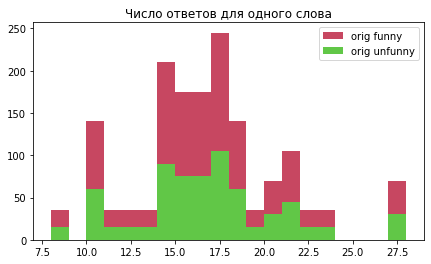

In [13]:
only_f = df[df['orig_funny'] == 1.0]
only_u = df[df['orig_funny'] == 0.0]

fig, ax = plt.subplots(figsize=(7,4))
ax.hist(only_u['count'], bins=20, color=ucolor)
ax.hist(only_f['count'], bins=20, color=fcolor)
ax.legend(['orig funny', 'orig unfunny'])
ax.set_title('Число ответов для одного слова')

Не ясно, прочему гистограмма такая. 

Это какие-то особенности работы программы для опросов.
Но распределение одинаковое для смешных и несмешных, и разброс не большой, поэтому закроем на это глаза

Text(0.5, 1.0, 'Изначально смешные / несмешные слова = 30/70')

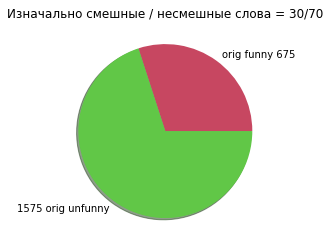

In [14]:
for_pie = [df[df['orig_funny'] == 1].shape[0], 
           df[df['orig_funny'] == 0].shape[0]]

plt.pie(for_pie, shadow=True, 
        labels=[f"orig funny {for_pie[0]}", f"{for_pie[1]} orig unfunny"], colors=[ucolor,fcolor])
plt.gca().set_title('Изначально смешные / несмешные слова = 30/70')

#### Демография

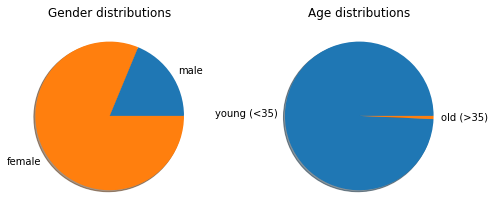

In [15]:
gend = [calibers.loc[0]['male_count'], calibers.loc[0]['female_count']]
age = [calibers.loc[0]['youngly_count'], calibers.loc[0]['elderly_count']]

fig,ax = plt.subplots(figsize=(7,5), nrows=1, ncols=2)
ax[0].pie(gend, shadow=True, labels=['male', 'female'])
ax[0].set_title('Gender distributions')
ax[1].pie(age, shadow=True, labels=['young (<35)', 'old (>35)'])
ax[1].set_title('Age distributions')
plt.tight_layout()

Очень несбалансированная выборка. Поэтому анализом в демографических подгруппах можно и не заниматься.

In [16]:
df.columns

Index(['word', 'orig_funny', 'count', 'mean', 'std', 'male_count', 'male_mean',
       'male_std', 'female_count', 'female_mean', 'female_std',
       'youngly_count', 'youngly_mean', 'youngly_std', 'elderly_count',
       'elderly_mean', 'elderly_std'],
      dtype='object')

In [17]:
df.drop(columns=['male_count','male_mean', 'male_std', 
                 'female_count', 'female_mean', 'female_std',
                 'youngly_count', 'youngly_mean', 'youngly_std', 
                 'elderly_count','elderly_mean', 'elderly_std'], inplace=True)

#### Mean ratings

Text(0.5, 1.0, 'Ratings hist')

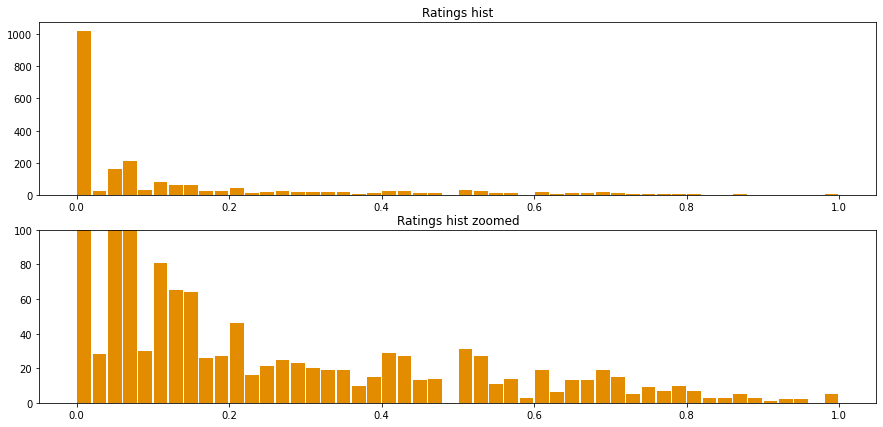

In [18]:
fig, ax = plt.subplots(nrows=2,figsize=(15,7))

ax[1].hist(df['mean'], bins=50, color='#e38c00', rwidth=0.9)
ax[1].set_title('Ratings hist zoomed')
ax[1].set_ylim(0,100)

ax[0].hist(df['mean'], bins=50, color='#e38c00', rwidth=0.9)
ax[0].set_title('Ratings hist')

#Шаг в 0.02

Очень много отмечено несмешными (ура!). В остальном довольно интересное распределение.

Можно посмотреть, как размеченные смешные соотносятся с изначальными смешными

Text(0.5, 1.0, 'Mean hist on log')

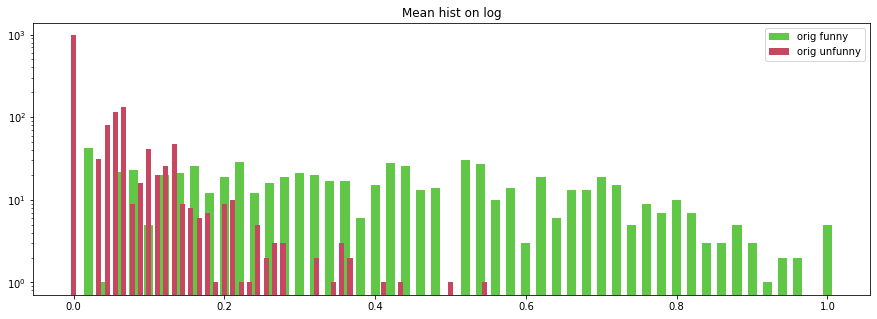

In [19]:
fig, ax = plt.subplots(figsize=(15,5))
ax.hist(only_f['mean'], bins=50, color=fcolor, log=True, align='right', rwidth=0.6)
ax.hist(only_u['mean'], bins=50, color=ucolor, log=True, align='left', rwidth=0.6)
ax.legend(['orig funny', 'orig unfunny'])
ax.set_title('Mean hist on log')

### Определяем порог

In [20]:
def mark_treshold(mean_rate, tres):
    if mean_rate <= tres:
        return 0
    else:
        return 1

In [21]:
def define_treshold(tres, ret=False, mark=False):
    fun = df[df['mean'] > tres]
    unfun = df[df['mean'] <= tres]
    
    if ret is True:
        return fun, unfun
    
    else:
        fun = float(df[df['mean'] > tres].shape[0])
        unfun = float(df[df['mean'] <= tres].shape[0])
        perc = (fun+unfun)/100
        
        print('For theshold', tres, ':')
        print('Percentage = ', "{:.2f}".format(fun / perc), 'fun vs', "{:.2f}".format(unfun / perc), 'unfun')
        print('Number = ', fun, 'fun vs', unfun, 'unfun')
        
    if mark is True:
        df['target'] = [mark_treshold(row, tres) for row in df['mean']]

Сделаем порог в 0.5. Во-первых это логично, во-вторых меньше – нереально.

In [22]:
res_f, res_u = define_treshold(0.5, ret=True)

In [23]:
define_treshold(0.5, mark=True)

For theshold 0.5 :
Percentage =  8.98 fun vs 91.02 unfun
Number =  202.0 fun vs 2048.0 unfun


### Std 
В данном случае std можно прочитывать как спорность слова: чем больше разброс, тем более горячий спор о том, смешное ли слово.

Text(0.5, 1.0, 'STD resulting funny (hist on log)')

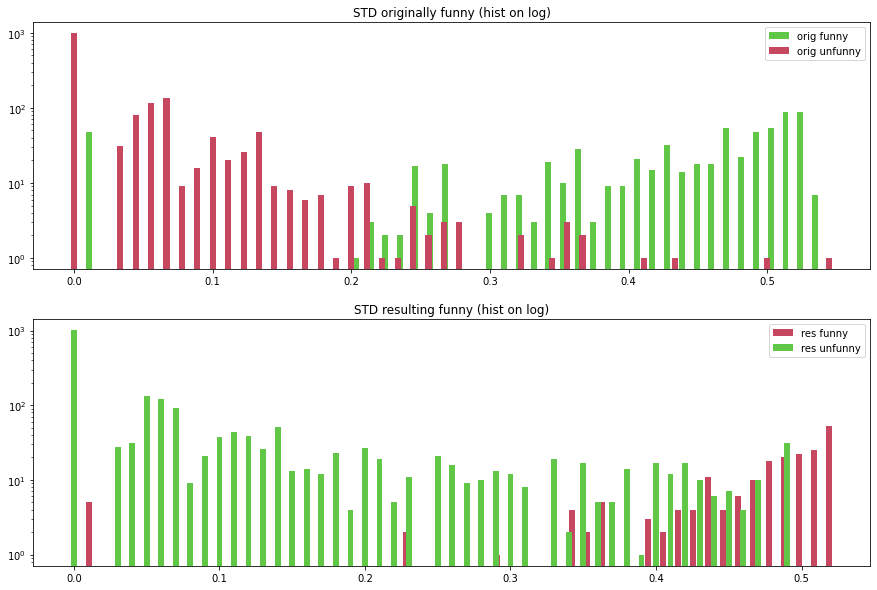

In [24]:
fig, ax = plt.subplots(nrows=2, figsize=(15,10))
ax[0].hist(only_f['std'], bins=50, color=fcolor, log=True, align='right', rwidth=0.4)
ax[0].hist(only_u['mean'], bins=50, color=ucolor, log=True, align='left', rwidth=0.4)
ax[0].legend(['orig funny', 'orig unfunny'])
ax[0].set_title('STD originally funny (hist on log)')

ax[1].hist(res_f['std'], bins=50, color=ucolor, log=True, align='right', rwidth=0.4)
ax[1].hist(res_u['mean'], bins=50, color=fcolor, log=True, align='left', rwidth=0.4)
ax[1].legend(['res funny', 'res unfunny'])
ax[1].set_title('STD resulting funny (hist on log)')

Интресно, что наиболее спорные – изначально смешные. Спорность несмешных последовательно падает.

# ВОТ, ЧТО ТАКОЕ СМЕШНЫЕ СЛОВА!

In [25]:
# Смешные слова в порядке смешности
pd.set_option('display.max_rows', res_f.shape[0]) 
res_f.sort_values('mean', ascending=False)

,word,orig_funny,count,mean,std
2236,эчпочмак,1,14.0,1.000000,0.000000
2082,фунфырик,1,13.0,1.000000,0.000000
618,кандибобер,1,17.0,1.000000,0.000000
118,бубылда,1,14.0,1.000000,0.000000
450,жабик,1,13.0,1.000000,0.000000
423,дудонить,1,21.0,0.952381,0.218218
2159,чилипиздрик,1,21.0,0.952381,0.218218
1556,пуцка,1,14.0,0.928571,0.267261
738,кошонята,1,14.0,0.928571,0.267261
1235,пек-пек-пек,1,12.0,0.916667,0.288675


# Feature engineering

Удалим лишнюю информацию и перейдем к генерации свойств.

In [26]:
from sklearn.model_selection import train_test_split

На этом этапе делаю тест-трейн сплит (чтобы корректно делать feature selection)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['target','orig_funny', 'count', 'mean', 'std']),
                                                    df['target'], test_size=0.15, random_state=42)

## Лемматизация

Для начала просто лемматизируем все слова. Это будет нужно и для работы с вики, и для работы с векторными моделями

In [28]:
m = Mystem()
wrong_words = []

mapping_url = 'https://raw.githubusercontent.com/akutuzov/universal-pos-tags/4653e8a9154e93fe2f417c7fdb7a357b7d6ce333/ru-rnc.map'
mystem2upos = {}
r = requests.get(mapping_url, stream=True)
for pair in r.text.split('\n'):
    pair = pair.split()
    if len(pair) > 1:
        mystem2upos[pair[0]] = pair[1]

def tag_mystem(text, bastards=True, mapping=mystem2upos):
    
    '''
Этот скрипт принимает на вход необработанный русский текст 
(одно предложение на строку или один абзац на строку).
Он токенизируется, лемматизируется и размечается по частям речи с использованием Mystem.
На выход подаётся последовательность разделенных пробелами лемм с частями речи 
("зеленый_NOUN трамвай_NOUN").

Сначала надо инициализировать m = MyStem()
'''
    
    
    # Обработка слов 
    text = text.strip() 
    processed = m.analyze(text)
    w = processed[0]
        
    try:
        lemma = w["analysis"][0]["lex"].lower().strip()
        pos = w["analysis"][0]["gr"].split(',')[0]
        pos = pos.split('=')[0].strip()
    except IndexError:
        print(w)
    
    if pos in mapping:
        pos = mapping[pos]  # здесь мы конвертируем тэги
    else:
        pos = 'X'  # на случай, если попадется тэг, которого нет в маппинге
    
    tagged = lemma.lower() + '_' + pos
    
    bast = 0
    if bastards is True:
        try:
            if w['analysis'][0]['qual'] == 'bastard':
                bast = 1
        except KeyError:
            pass
    
    return tagged, bast

In [29]:
def detag(string):
    lim = string.find('_')
    if string[lim:] == '_PROPN':
        return string[:lim].capitalize()
    else:
        return string[:lim]

In [30]:
# Подвиг лизы, поправившей все слова
wrong_marked = {'шаболд_NOUN':'шаболда_NOUN', 
                'порабабан_NOUN':'порабабану_ADV', 
                'нунчак_NOUN':'нунчаки_NOUN',
                'пуцк_NOUN':'пуцка_NOUN',
                'епстудэй_NOUN':'епстудэй_INTJ',
                'гнидок_NOUN':'гнидка_NOUN',
                'ебак_NOUN':'ебака_NOUN',
                'продриснять_VERB':'продриснуть_VERB',
                'кабас_NOUN':'кабаса_NOUN',
                'кутешат_NOUN':'кутешонок_NOUN',
                'ебенить_VERB':'ебеня_NOUN',
                'охйовзес_NOUN':'охйовзес_INTJ',
                'астралябия_NOUN':'астролябия_NOUN',
                'плюмбум_ADV':'плюмбум_NOUN',
                'гупешок_NOUN':'гупешка_NOUN',
                'мыш_NOUN':'мышь_NOUN',
                'треугольничка_NOUN':'треугольничек_NOUN',
                'яселек_NOUN':'ясельки_NOUN',
                'блеб_NOUN':'блеба_NOUN',
                'чупакабр_NOUN':'чупакабра_NOUN',
                'бровье_NOUN':'бровь_NOUN',
                'мюзле_ADV':'мюзле_NOUN',
                'дудык_NOUN':'дудыка_NOUN',
                'зимбур_NOUN':'зимбура_NOUN',
                'посюстороной_ADJ':'посюсторонний_ADJ',
                'сукалень_NOUN':'сукалень_INTJ',
                'уевмененький_ADJ':'уевмененько_ADV',
                'ювелирок_NOUN':'ювелирка_NOUN',
                'ржомб_NOUN':'ржомба_NOUN',
                'шлюшандр_NOUN':'шлюшандра_NOUN',
                'мамонный_ADJ':'мамона_PROPN',
                'апоп_NOUN':'апоп_PROPN',
                'зазауль_NOUN':'зазауля_NOUN',
                'сподвыподверт_NOUN':'сподвыподвертом_ADV',
                'изподподвыподверт_NOUN':'изподподвыподверта_ADV',
                'обезьяньяног_NOUN':'обезьяньянога_NOUN',
                'фаберже_NOUN':'фаберже_PROPN',
                'престидиджижитатор_NOUN':'престидижитатор_NOUN',
                'чевапчича_NOUN':'чевапчичи_NOUN',
                'колыван_NOUN':'колыван_PROPN',
                'скокм_NOUN':'скокма_PRON',
                'барбариск_NOUN':'барбариска_NOUN',
                'дапкунать_VERB':'дапкунайте_PROPN',
                'попандопадать_VERB':'попандопуло_PROPN',
                'володя_NOUN':'володя_PROPN',
                'черномырдин_NOUN':'черномырдин_PROPN',
                'краков_NOUN':'краков_PROPN',
                'чулышман_NOUN':'чулышман_PROPN',
                'исключительно_PART':'исключительно_ADV',
                'когда_ADV':'когда_SCONJ',
                'ингеборга_NOUN':'ингеборга_PROPN',
                'ауфа_NOUN':'ауф_INTJ',
                'иной_DET':'иной_PRON',
                'один_DET':'один_NUM',
                'крым_NOUN':'крым_PROPN',
                'гваделупа_NOUN':'гваделупа_PROPN',
                'никак_PART':'никак_PRON',
                'ядвига_NOUN':'ядвига_PROPN',
                'карл_NOUN':'карл_PROPN',
                'после_ADV':'после_ADP',
                'александр_NOUN':'александр_PROPN',
                'федор_NOUN':'федор_PROPN',
                'сызрань_NOUN':'сызрань_PROPN',
                'илья_NOUN':'илья_PROPN',
                'вилли_NOUN':'вилли_PROPN',
                'камю_NOUN':'камю_PROPN',
                'бугульма_NOUN':'бугульма_PROPN',
                'однако_SCONJ':'однако_INTJ',
                'куда_ADV':'куда_PRON',
                'почти_ADV':'почти_ADP',
                'ванючка_NOUN':'вонючка_NOUN'
                }

In [31]:
def eng_lemma(df, corrections=wrong_marked):
    df['stem_bastard'] = [0] * df.shape[0]
    for w in df['word']:
        index = df[df['word'] == w].index[0]
        stemed, bast = tag_mystem(w)
        
        if corrections is not None:
            if stemed in wrong_marked:
                stemed = corrections.get(stemed)
        
        df.loc[index, 'stem'] = stemed
        df.loc[index, 'stem_bastard'] = bast
        try:
            df.loc[index, 'detagged'] = detag(stemed)
        except AttributeError:
            print(w, stemed, type(stemed))

In [32]:
eng_lemma(X_train)
print(f"Tagged {len(X_train['stem'])} words out of {X_train.shape[0]} \nThere are {X_train[X_train['stem_bastard'] == 1].shape[0]} bastards")

Tagged 1912 words out of 1912 
There are 163 bastards


In [33]:
eng_lemma(X_test)

## Formal

Для каждого типа признаков пишу функцию, его задающую; в конце пишу функцию, вызывающую все предыдущие функции.

### Длины слов

In [34]:
def eng_length(data):
    data['length'] = [len(w.strip()) for w in data['word']]

In [35]:
eng_length(X_train)
eng_length(X_test)

### N-gram

План такой:

1) Делаем все n-gramm-ы до 3 (?) букв.

2) После выбираем лучшие n-gramms (kBest, logistic reg или встречаемость в смешных-несмешных?)

3) Пишим функцию препроцессинга для выделения этих n-gramms

--

#### 1) Векторизируем n-grams
Сделал ограничение: минимум встречаемости – 5 слов

In [78]:
# Смотрим сначала на униграммы
cv = CountVectorizer(analyzer='char_wb', min_df=5).fit(X_train['word'])
uni_train = cv.transform(X_train['word'])
uni_test = cv.transform(X_test['word'])
uni_names = cv.get_feature_names()
print(uni_names)

[' ', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я', 'ё']


In [79]:
#По 3-буквенным сочетаниям

cv = CountVectorizer(ngram_range=(1, 3), analyzer='char_wb', min_df=5)
cv.fit(X_train['word'])
ngram_train = cv.transform(X_train['word'])
ngram_test = cv.transform(X_test['word'])
ngram_names = cv.get_feature_names()

#### 2a) Обучаем логистическую регрессию


In [80]:
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_roc_curve
from sklearn.ensemble import RandomForestClassifier

In [81]:
def find_words(string):
    """
    Возвращает смешные и несмешные слова, в которых есть данная строка
    """
    counter = 0
    print('Смешные:')
    for item in df[df['target'] == 1]['word']:
        if string in item:
            print(item)
            counter += 1
    print(counter, '\n')
            
    counter = 0
    print('Несмешные:')
    for item in df[df['target'] == 0]['word']:
        if string in item:
            print(item)
            counter += 1
    print(counter)

In [82]:
def top_features(importance_array, n_features, title='feature importance', plot=True, names=ngram_names):
    d = pd.DataFrame(data = importance_array, index = names, columns=['Importance'])
    d = d.sort_values(by = 'Importance', ascending = False)
    if plot is True:
        return d[0:n_features].plot(kind='bar', title=title)
    else:
        return d[0:n_features]

In [83]:
#Функция для визуализации лучших коэффицентов. Чтобы посмотреть, как обстоит дело
def visualize_coefficients(classifier, feature_names, n_top_features=25, title=None):
    # get coefficients with large absolute values 
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    # plot them
    plt.figure(figsize=(17, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features), feature_names[interesting_coefficients], rotation=60, ha="right");
    plt.gca().set_title(title)

Посмотрим сперва, как ведет себя на униграммах.

In [84]:
log = LogisticRegression().fit(uni_train, y_train)

Text(0.5, 1.0, 'test score')

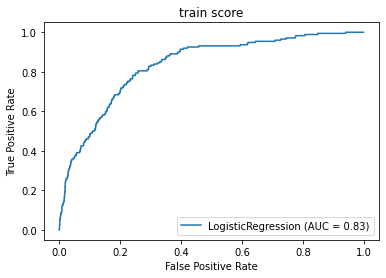

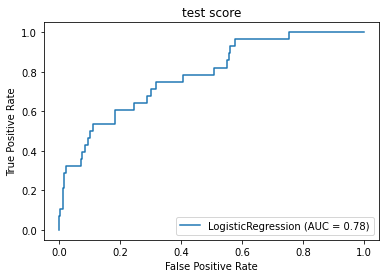

In [85]:
plot_roc_curve(log, uni_train, y_train)
plt.gca().set_title('train score')

plot_roc_curve(log, uni_test, y_test)
plt.gca().set_title('test score')

Результат ожидаемо плохой. Но я делал это не ради качества, а ради этого графика:

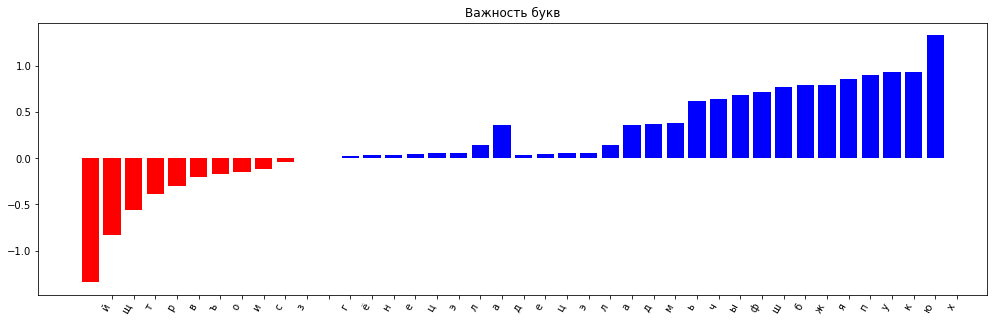

In [86]:
visualize_coefficients(log, uni_names, n_top_features=20, title='Важность букв')

**Замечания:**

Слова на "й" (самая несмешная буква) – во многом окончания прилагательных. Неожиданно, но ладно.

Самая смешная буква – 'х'. Не только из-за "хуев"! 

Дальше идет "ю", чуть позже "у". Может ли это быть подтверждением нашего предположения о том, что звук "у" как в "мюсли" – принципиально смешной? 

Рядом "К". Вспоминается 'k' как самая смешная согласная английского алфавита.

Среди смешных есть дефис. Это результат того, что изначально несмешные слова я чистил по знакам препинания, а смешные – нет.

In [87]:
log = LogisticRegression().fit(ngram_train,y_train)

/Users/pasace/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Text(0.5, 1.0, 'test score')

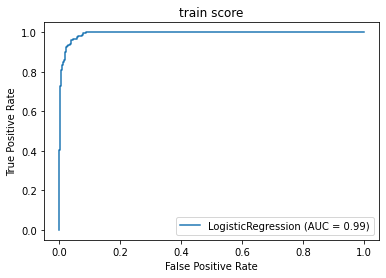

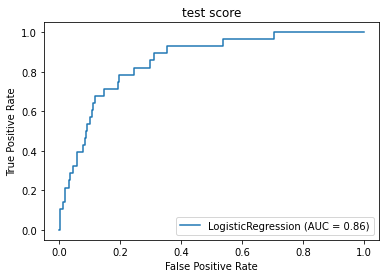

In [88]:
plot_roc_curve(log, ngram_train, y_train)
plt.gca().set_title('train score')

plot_roc_curve(log, ngram_test, y_test)
plt.gca().set_title('test score')

Уже уже намного лучше! Не удивительно, здесь 4326 признаков!

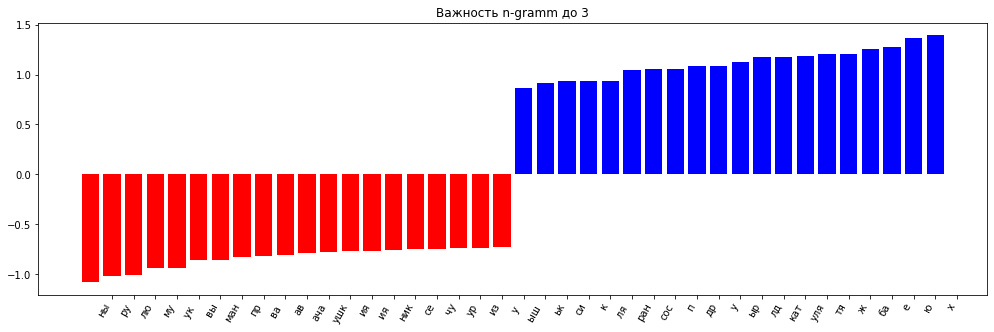

In [89]:
visualize_coefficients(log, cv.get_feature_names(), n_top_features=20, title='Важность n-gramm до 3')

**Из предварительных наблюдений:**
    
"Х" и "ю" сохраняет позиции

Встречаются пары буквосочетания "сос" (до этого еще был "кок"). Может стоить ввести признак "повторяющаяяся буква"?

**Главный вопрос:** до какой степени мы можем использовать n-grammы? Насколько они переобучаются? С другой стороны н-граммы вроде "уля" – очевидно интерпретируемы и смешны

#### 2b) Попробуем деревянной моделью

In [90]:
forest = RandomForestClassifier(random_state=42).fit(ngram_train, y_train)

Text(0.5, 1.0, 'test score')

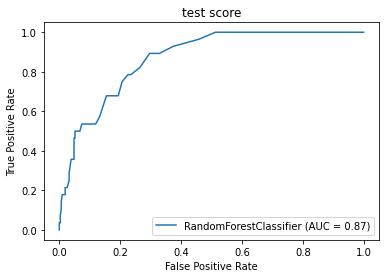

In [91]:
plot_roc_curve(forest, ngram_test, y_test)
plt.gca().set_title('test score')

Сравним оценку важности лесом и регрессией.

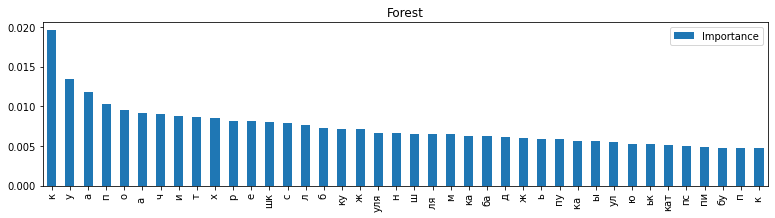

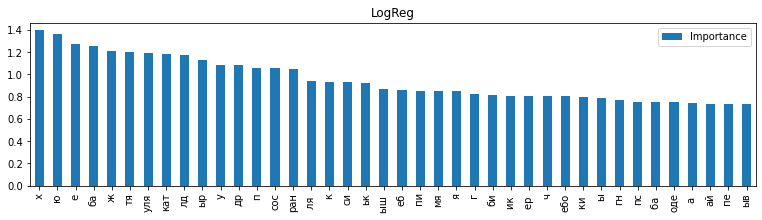

In [92]:
top_features(forest.feature_importances_, 40, title='Forest')
plt.gcf().set_size_inches((13,3))
top_features(log.coef_.T, 40, title='LogReg')
plt.gcf().set_size_inches((13,3))

**Странно:** к вышла в лидеры, а х и я ушли куда-то далеко. Как и раньше наивысшая важность у отдельных букв. Странно!

**Итого вопросы:** 

1) n-gramms могут быть подвержены переобучению. Брать их или все же униграммы?

2) Как выбрать feature которые вставлять. И сколько?

Посмотрим, какие пересекаются.

In [51]:
top_for = top_features(forest.feature_importances_, 100, plot=False)
top_log = top_features(log.coef_.T, 100, plot=False)

top_ngrams = []
for t in top_for.index:
    if t in top_log.index:
        top_ngrams.append(t)
        
print(f"Пересекаются {len(top_ngrams)} элементов: \n{top_ngrams}")

Пересекаются 46 элементов: 
['к', 'у', 'п', 'а ', 'ч', 'х', ' ж', 'уля', 'ля ', 'м', 'ба', 'ж', 'ы', 'ю', 'ьк', 'кат', 'пс', ' пи', 'ыр', 'я', 'в', 'пе', 'еб', 'шу', 'лд', 'ьки', 'ыш ', 'ля', ' х', ' е', 'ба ', 'ел', 'ан ', 'ик ', ' пе', 'мя', 'мы', 'тя', 'си', 'ки ', ' че', 'сос', 'др', 'бал', 'пи', 'ели']


In [52]:
def eng_ngramm(data):
    for ng in top_ngrams:
        col_name = 'ngramm ' + ng
        includes = []
        for w in data['word']:
            includes.append(len([m.start() for m in re.finditer(ng, w)]))
            
        data[col_name] = includes

In [53]:
eng_ngramm(X_train)
eng_ngramm(X_test)

### ВикиСловарь

Достаем оттуда транскрипции и классификацию слов

In [54]:
def eng_wiki(word_list):
    
    #Достаю словарные теги викисловаря
    tagpage = requests.get('https://ru.wiktionary.org/wiki/Викисловарь:Условные_сокращения')
    soup0 = BeautifulSoup(tagpage.content, 'html.parser')
    wiki_tags = []
    a_wiki_tags = soup0.findAll('ul')[1]
    b_wiki_tags = a_wiki_tags.findAll('i')
    for b in b_wiki_tags:
        c = b.string
        wiki_tags.append(c)
    
    # делаю колонки в датафрейме
    word_list['ipa'] = ['nan'] * word_list.shape[0]
    word_list['not in wiki'] = [0] * word_list.shape[0]
    for tag in wiki_tags:
        word_list[tag] = [0] * word_list.shape[0]
        
    
    
    #Скачиваю страницу каждого слова   
    for string in word_list['detagged']:
        index = word_list[word_list['detagged'] == string].index[0]
        
        w_link = 'https://ru.wiktionary.org/wiki/' + string
        page = requests.get(w_link)
        soup = BeautifulSoup(page.content, 'html.parser')
        
        # Транскрипция
        ip = soup.find('span', {'class': 'IPA'})
        if ip != None:
            word_list.loc[index,'ipa'] = str(ip.string)
        else:
            word_list.loc[index,'ipa'] = 'nan'
            
        # Добываем теги слова
        # Трай на случай, если его нет в словаре
        try:
            ol = soup.find_all('ol')[0]
            tagstags = ol.find_all('a', {'title':'Викисловарь:Условные сокращения'})
            actual_tags = []
            for tagtag in tagstags:
                tt = tagtag.findChildren('span')
                if tt[0].string in wiki_tags:
                    actual_tags.append(tt[0].string)
            #Вписываем в таблицу    
            for act in actual_tags:
                word_list.loc[index, act] = 1
                
        except IndexError:
            word_list.loc[index, 'not in wiki'] = 1

In [55]:
%%time
eng_wiki(X_train)

CPU times: user 2min 18s, sys: 3.29 s, total: 2min 21s
Wall time: 19min 17s


In [56]:
%%time
eng_wiki(X_test)

CPU times: user 24.2 s, sys: 573 ms, total: 24.8 s
Wall time: 3min 26s


In [57]:
X_train['ipa']

1723        ˈskolʲskʲɪɪ̯
2096    xʲɪrɐˈmanʲtʲɪɪ̯ə
1772          sɐˈfkovɨɪ̯
65            bɐˈsʲːeɪ̯n
508        zənʲɪˈmat͡sːə
              ...       
1638               rublʲ
1095         ɐpˈɕːaʐnɨɪ̯
1130            onˈɫaɪ̯n
1294             ˈplʲuxə
860         ˈmarkʲɪtʲɪnk
Name: ipa, Length: 1912, dtype: object

In [58]:
print(f"Есть транскрипция для {len(X_train.ipa[X_train.ipa != 'nan'])} слов.\nНет для {len(X_train.ipa[X_train.ipa == 'nan'])}.")

Есть транскрипция для 1760 слов.
Нет для 152.


### Фонетика

#### Разделяем фонемы

In [102]:
#ВРЕМЕННАЯ ШТУКА
train = pd.read_csv('https://github.com/Chernechev/RussianFWords/raw/main/train.csv', index_col='Unnamed: 0')
test = pd.read_csv('https://github.com/Chernechev/RussianFWords/raw/main/test.csv', index_col='Unnamed: 0')
y_train = train['target']
X_train = train.drop('target', axis=1)
y_test = test['target']
X_test = test.drop('target', axis=1)

In [103]:
#Парсим список фонем. Список существующих фонем – phs
mfa = requests.get('https://ru.wikipedia.org/wiki/Таблица_МФА_для_русского_языка')
soupmfa = BeautifulSoup(mfa.content, 'html.parser')
spans = soupmfa.findAll('span', {'class': 'IPA'})
phs = []
for sp in spans:
    atags = sp.findAll('a')
    complete = []
    for a in atags:
        complete.append(a.contents[0])
    phoneme = ''.join(complete)
    chars = list(phoneme)
    for s in chars:
        if unicodedata.combining(s) != 0:
            if unicodedata.name(s) == 'COMBINING PLUS SIGN BELOW':
                s = 'ʲ'
            else:
                chars.remove(s)
    phoneme = ''.join(chars)
    
    if phoneme not in phs:
        phs.append(phoneme)
        
errors = ['ˈ◌','ɪˈtap', 'ˌ◌', 'ˌokəɫɐˈzʲemnɨɪ', '', 'ɕtɕ']
for err in errors:
    try:
        phs.remove(err)
    except ValueError:
        pass

In [104]:
def only_fonetic(df, other_df=None):
    fon_list = []
    for l in df['ipa']:
        if type(l) != str:
            fon_list.append(False)
        else:
            fon_list.append(True)
    if other_df is None:
        return df[fon_list]
    else:
        return other_df[fon_list]

In [105]:
# Делаю bag of sounds, чтобы посмотреть
fonetic_train = only_fonetic(X_train)
fonetic_test = only_fonetic(X_test)
fonetic_train_y = only_fonetic(X_train, other_df=y_train)
fonetic_test_y = only_fonetic(X_test, other_df=y_test)

#### Raw ipa signs

In [33]:
cv = CountVectorizer(analyzer='char_wb', min_df=5)
cv.fit(fonetic_train['ipa'])
signs_train = cv.transform(fonetic_train['ipa'])
signs_test = cv.transform(fonetic_test['ipa'])
signs_names = cv.get_feature_names()

In [34]:
#Обучаю модель чтобы получить самые смешные звуки
log = LogisticRegression().fit(signs_train, fonetic_train_y)

Text(0.5, 1.0, 'test score')

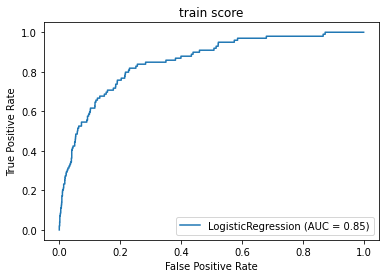

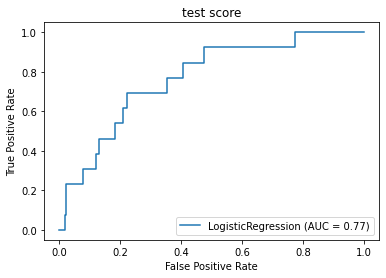

In [35]:
plot_roc_curve(log, signs_train, fonetic_train_y)
plt.gca().set_title('train score')

plot_roc_curve(log, signs_test, fonetic_test_y)
plt.gca().set_title('test score')

In [36]:
top_features(log.coef_.T, 10, title='Top ipa signs', names=signs_names)
plt.gcf().set_size_inches((13,3))

NameError: name 'top_features' is not defined

In [37]:
top_signs = top_features(log.coef_.T, 10, plot=False, names=signs_names).T

NameError: name 'top_features' is not defined

Интересно, что как и в ngrams важно "х" и "у". Надо отметить, что '͡' и 'ʲ' – это части составных фонем. Следует выделить их наличие в отдельный признах 

#### Превращаем в признак

In [71]:
def eng_signs(data):
    for ng in top_signs:
        col_name = 'sign ' + ng
        includes = []
        for w in data['ipa']:
            includes.append(len([m.start() for m in re.finditer(ng, w)]))
            
        data[col_name] = includes

In [72]:
eng_signs(X_train)
eng_signs(X_test)

### Фонемы

In [73]:
sounds_names = ['sound ' + ph for ph in phs]

def phonetize(fonetic_df):
    sounds_df = pd.DataFrame(columns = sounds_names, index=fonetic_df.index)
    for index in fonetic_df.index:
        w = fonetic_df.at[index, 'ipa']
        for ph in phs:
            try:
                if ph in w:
                    sounds_df.at[index, f"sound {ph}"] = 1
                else:
                    sounds_df.at[index, f"sound {ph}"] = 0
            except TypeError:
                print('Нечистый фонетик дф дан на вход!')
    return sounds_df

In [74]:
sounds_train = phonetize(fonetic_train)
sounds_test = phonetize(fonetic_test)

In [75]:
sounds_log = LogisticRegression().fit(sounds_train, fonetic_train_y)

Text(0.5, 1.0, 'test score')

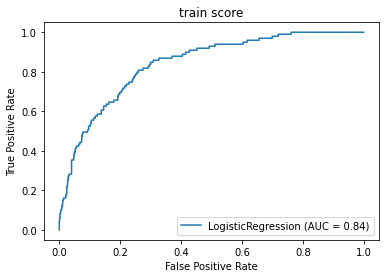

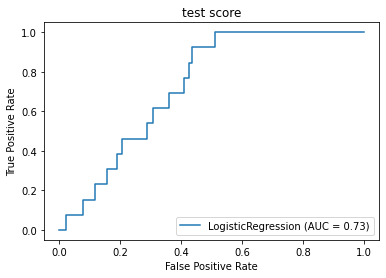

In [76]:
plot_roc_curve(sounds_log, sounds_train, fonetic_train_y)
plt.gca().set_title('train score')

plot_roc_curve(sounds_log, sounds_test, fonetic_test_y)
plt.gca().set_title('test score')

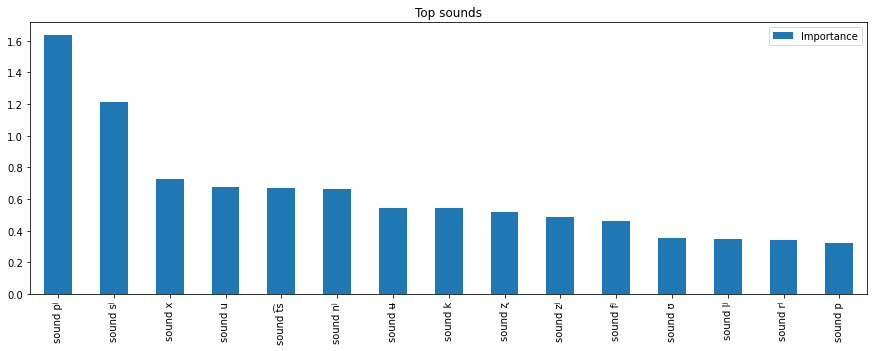

In [93]:
top_features(sounds_log.coef_.T, 15, title='Top sounds', names=sounds_names)
plt.gcf().set_size_inches((15,5))

top_sounds = top_features(sounds_log.coef_.T, 15, plot=False, names=sounds_names).T

#### Превращаем в признак

In [106]:
def eng_sounds(data):
    fonetic_df = phonetize(only_fonetic(data))
    for sound in top_sounds.columns:
        data[sound] = fonetic_df[sound]

In [107]:
eng_sounds(X_train)
eng_sounds(X_test)

 **ЗДЕСЬ НАДО ИСПОЛЬЗОВАТЬ ТЕТРАДЬ corpus_spider (работает 70 мин на трейне) ДЛЯ ПОЛУЧЕНИЯ ЧАСТОТНОСТИ СЛОВ**

## Препроцессинг целиком

In [73]:
def preprocess(df, name):
    """
    На вход подается датафрейм состоящий только из колонки 'word', в которой слова
    """
    eng_lemma(df)
    eng_length(df)
    eng_ngramm(df)
    eng_wiki(df)
    eng_signs(df)
    eng_sounds(df)
    
    df.to_csv(name)
    # Плюс еще нужно сделать частоту (в другой тетрадке)

In [108]:
## Экспортируем то, что получилось

train = pd.concat([X_train, y_train], axis=1)
train.to_csv('train.csv')
test = pd.concat([X_test, y_test], axis=1)
test.to_csv('test.csv')

In [ ]:
pd.set_option('display.max_columns', test.shape[1]) 
test